# Load Package

In [1]:
pip install fuzzywuzzy

In [2]:
pip install nfl_data_py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which i

In [3]:
import pandas as pd
import numpy as np
from io import StringIO
import requests

import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
import xarray as xr
from fuzzywuzzy import process

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import nfl_data_py as nfl
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 1. Load Datasets and Process

In [4]:
file_id = '1YvI39ir3sF9B962OUnt0Vs40756yscl4'
url = f'https://drive.google.com/uc?id={file_id}'

response = requests.get(url)
csv_content = response.content.decode('utf-8')


original_dataset = pd.read_csv(StringIO(csv_content))
sports_data = original_dataset.copy()

In [5]:
sports_data.shape

(14073, 26)

In [6]:
# Dropping unnecessary columns
sports_data = sports_data.drop(columns=[col for col in sports_data.columns if 'Unnamed' in col])

In [7]:
sports_data.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN


### Filter to only included recorded games

In [8]:
sports_data['schedule_date'] = pd.to_datetime(sports_data['schedule_date'])

# Filter events on or before Sep 2024.
filtered_sports_data = sports_data[sports_data['schedule_date'] <= '2024-09-30']

filtered_sports_data

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,1966-09-02,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,1966-09-03,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,1966-09-04,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,1966-09-09,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,1966-09-10,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13860,2024-09-29,2024,4,False,New York Jets,9.0,10.0,Denver Broncos,NYJ,-8.0,39.5,MetLife Stadium,False,NaN,NaN,NaN,NaN
13861,2024-09-29,2024,4,False,San Francisco 49ers,30.0,13.0,New England Patriots,SF,-10.5,41.5,Levi's Stadium,False,NaN,NaN,NaN,NaN
13862,2024-09-29,2024,4,False,Tampa Bay Buccaneers,33.0,16.0,Philadelphia Eagles,PHI,-1.0,42.5,Raymond James Stadium,False,NaN,NaN,NaN,NaN
13863,2024-09-30,2024,4,False,Detroit Lions,42.0,29.0,Seattle Seahawks,DET,-4.0,47,Ford Field,False,72.0,0.0,NaN,indoor


### Fill NAN - grouped fill

In [9]:
filtered_sports_data.isnull().sum()

,0
schedule_date,0
schedule_season,0
schedule_week,0
schedule_playoff,0
team_home,0
score_home,0
score_away,0
team_away,0
team_favorite_id,2479
spread_favorite,2479


In [10]:
# seperate month, year
filtered_sports_data['month'] = filtered_sports_data.schedule_date.dt.month
filtered_sports_data['year'] = filtered_sports_data.schedule_date.dt.year

<ipython-input-10-87bb214e1039>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sports_data['month'] = filtered_sports_data.schedule_date.dt.month
<ipython-input-10-87bb214e1039>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sports_data['year'] = filtered_sports_data.schedule_date.dt.year


In [11]:
# Group 1: Median values for the same "stadium" of the same month and year
median_stadium_month_year = (
    filtered_sports_data.groupby(['stadium', 'month', 'year'])[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]
    .median(numeric_only=True)
)

# Group 2: Median values for the same "stadium" of the same month (all years)
median_stadium_month = (
    filtered_sports_data.groupby(['stadium', 'month'])[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]
    .median(numeric_only=True)
)

# Group 3: Median values for the same month and year (all stadiums)
median_month_year = (
    filtered_sports_data.groupby(['month', 'year'])[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]
    .median(numeric_only=True)
)

# Function to impute missing weather data
def impute_weather(row):
    key_stadium_month_year = (row['stadium'], row['month'], row['year'])
    key_stadium_month = (row['stadium'], row['month'])
    key_month_year = (row['month'], row['year'])

    for col in ['weather_temperature', 'weather_wind_mph', 'weather_humidity']:
        if pd.isnull(row[col]):
            if key_stadium_month_year in median_stadium_month_year.index:
                row[col] = median_stadium_month_year.loc[key_stadium_month_year, col]
            elif key_stadium_month in median_stadium_month.index:
                row[col] = median_stadium_month.loc[key_stadium_month, col]
            elif key_month_year in median_month_year.index:
                row[col] = median_month_year.loc[key_month_year, col]
    return row

filtered_sports_data = filtered_sports_data.apply(impute_weather, axis=1)

# Convert columns back to numeric after imputation
for col in ['weather_temperature', 'weather_wind_mph', 'weather_humidity']:
    filtered_sports_data[col] = pd.to_numeric(filtered_sports_data[col], errors='coerce')


In [12]:
# Grouping by team matchups and calculating the median for each group
median_values = (
    filtered_sports_data.groupby(['team_home', 'team_away'])[['spread_favorite', 'over_under_line']]
    .apply(lambda group: group.apply(pd.to_numeric, errors='coerce').median())
)

# Function to impute missing values using the median values from the same matchup
def impute_missing_values(row):
    try:
        # Ensure numeric conversion for the row
        spread_favorite_median = median_values.loc[(row['team_home'], row['team_away']), 'spread_favorite']
        over_under_line_median = median_values.loc[(row['team_home'], row['team_away']), 'over_under_line']

        if pd.isnull(row['spread_favorite']):
            row['spread_favorite'] = spread_favorite_median
        if pd.isnull(row['over_under_line']):
            row['over_under_line'] = over_under_line_median
    except KeyError:
        # Handle cases where the group doesn't exist in median_values
        pass
    return row

filtered_sports_data = filtered_sports_data.apply(impute_missing_values, axis=1)

In [13]:
filtered_sports_data.isnull().sum()

,0
schedule_date,0
schedule_season,0
schedule_week,0
schedule_playoff,0
team_home,0
score_home,0
score_away,0
team_away,0
team_favorite_id,2479
spread_favorite,119


### Fill NAN - mean

In [14]:
filtered_sports_data['over_under_line'] = pd.to_numeric(filtered_sports_data['over_under_line'], errors='coerce')

spread_median = filtered_sports_data['spread_favorite'].median()
over_under_median = filtered_sports_data['over_under_line'].median()

filtered_sports_data['spread_favorite'].fillna(spread_median, inplace=True)
filtered_sports_data['over_under_line'].fillna(over_under_median, inplace=True)

temp_median = filtered_sports_data['weather_temperature'].median()
wind_median = filtered_sports_data['weather_wind_mph'].median()

filtered_sports_data['weather_temperature'].fillna(temp_median, inplace=True)
filtered_sports_data['weather_wind_mph'].fillna(wind_median, inplace=True)


Betting columns (spread_favorite and over_under_line): Missing values were imputed with the median values.
Weather columns: weather_temperature and weather_wind_mph are now complete. However, weather_humidity and weather_detail still have substantial missing values.
Scores: score_home and score_away still have a small number of missing values, likely for games without recorded scores.

In [15]:
filtered_sports_data.isnull().sum()

,0
schedule_date,0
schedule_season,0
schedule_week,0
schedule_playoff,0
team_home,0
score_home,0
score_away,0
team_away,0
team_favorite_id,2479
spread_favorite,0


# 2. EAD

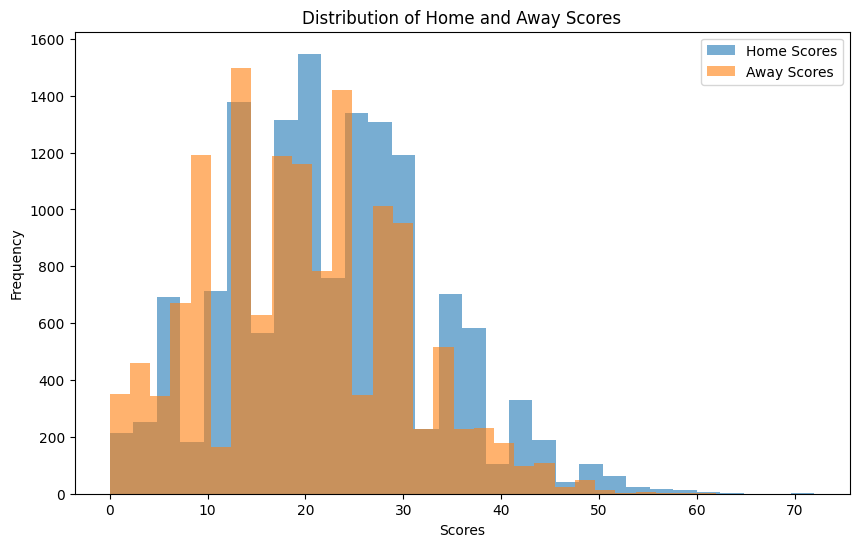

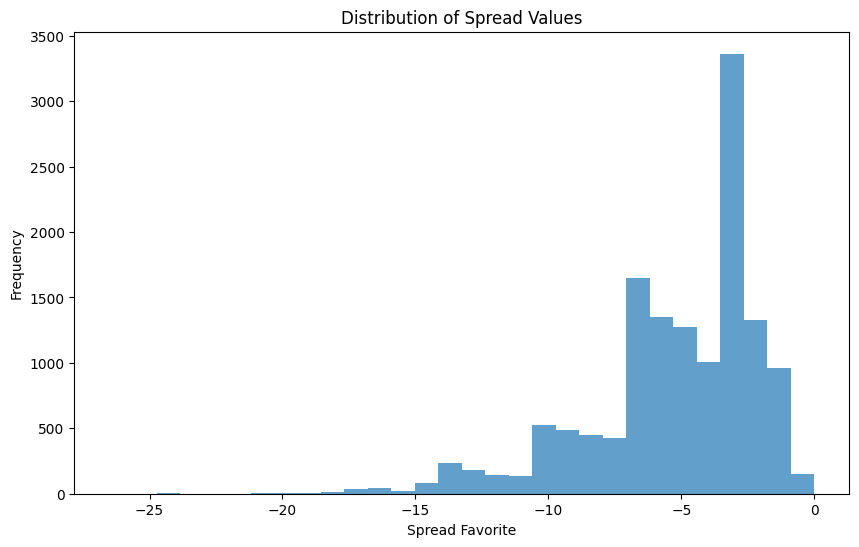

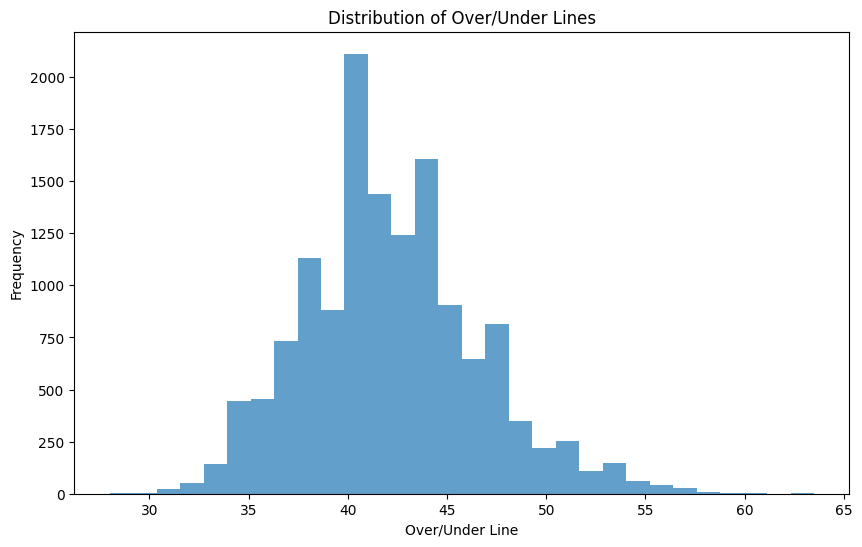

,score_home,score_away,spread_favorite,over_under_line
count,13865.000000,13865.000000,13865.000000,13865.000000
mean,22.478759,19.802885,-5.242373,42.220029
std,10.520156,10.146824,3.203553,4.442897
min,0.000000,0.000000,-26.500000,28.000000
25%,15.000000,13.000000,-7.000000,39.000000
50%,22.000000,20.000000,-4.500000,42.000000
75%,29.000000,27.000000,-3.000000,45.000000
max,72.000000,62.000000,0.000000,63.500000


In [16]:
filtered_data = filtered_sports_data.copy()
# Summary statistics for relevant numerical columns
summary_stats = filtered_data[['score_home', 'score_away', 'spread_favorite', 'over_under_line']].describe()

plt.figure(figsize=(10, 6))
plt.hist(filtered_data['score_home'].dropna(), bins=30, alpha=0.6, label='Home Scores')
plt.hist(filtered_data['score_away'].dropna(), bins=30, alpha=0.6, label='Away Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Home and Away Scores')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(filtered_data['spread_favorite'].dropna(), bins=30, alpha=0.7)
plt.xlabel('Spread Favorite')
plt.ylabel('Frequency')
plt.title('Distribution of Spread Values')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(filtered_data['over_under_line'].dropna(), bins=30, alpha=0.7)
plt.xlabel('Over/Under Line')
plt.ylabel('Frequency')
plt.title('Distribution of Over/Under Lines')
plt.show()

summary_stats


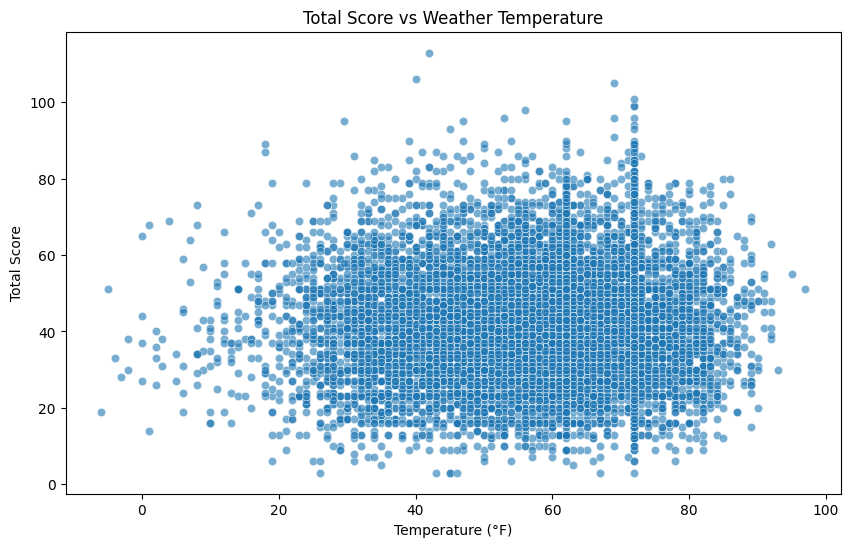

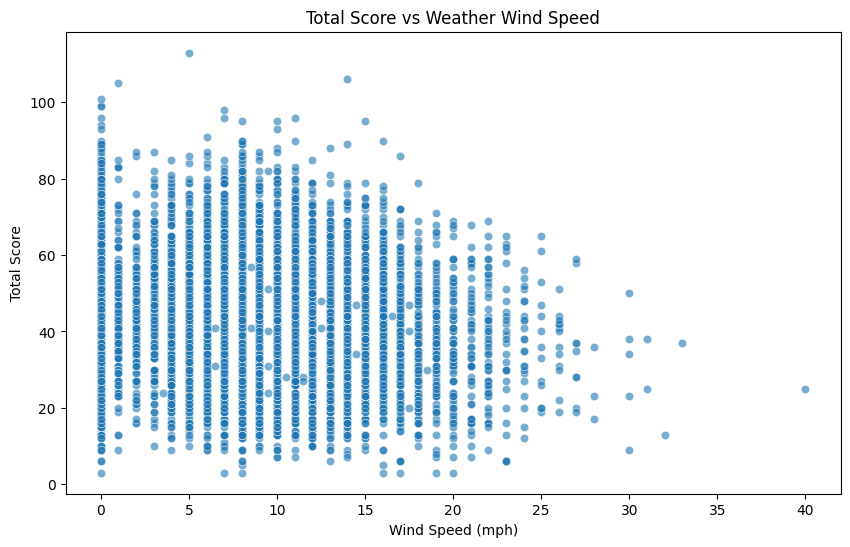

In [17]:
# Plot relationship between temperature and total score (home + away)
filtered_data['total_score'] = filtered_data['score_home'] + filtered_data['score_away']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='weather_temperature', y='total_score', data=filtered_data, alpha=0.6)
plt.title('Total Score vs Weather Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Total Score')
plt.show()

# Plot relationship between wind speed and total score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weather_wind_mph', y='total_score', data=filtered_data, alpha=0.6)
plt.title('Total Score vs Weather Wind Speed')
plt.xlabel('Wind Speed (mph)')
plt.ylabel('Total Score')
plt.show()


The scatter plots provide a look into how weather might impact game scores:

Temperature vs. Total Score:

There doesn’t seem to be a strong correlation between temperature and total score, with scores remaining fairly spread across the temperature range.
While higher temperatures may allow for marginally higher scores, the overall effect appears limited.
Wind Speed vs. Total Score:

Similarly, wind speed shows little effect on the total score, though extremely high wind speeds are rare and might contribute to slightly lower scores when they occur.
These results suggest that, within this dataset, weather conditions (temperature and wind) might have only a minor impact on overall game scoring.



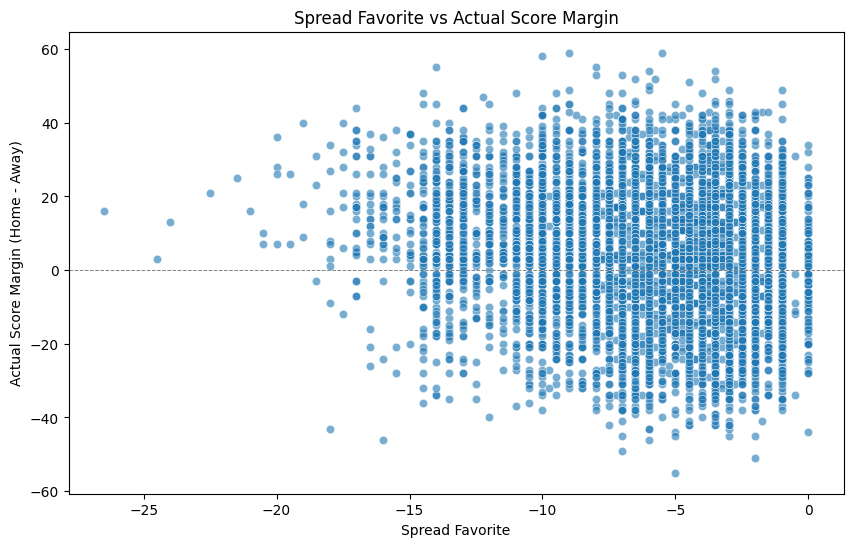

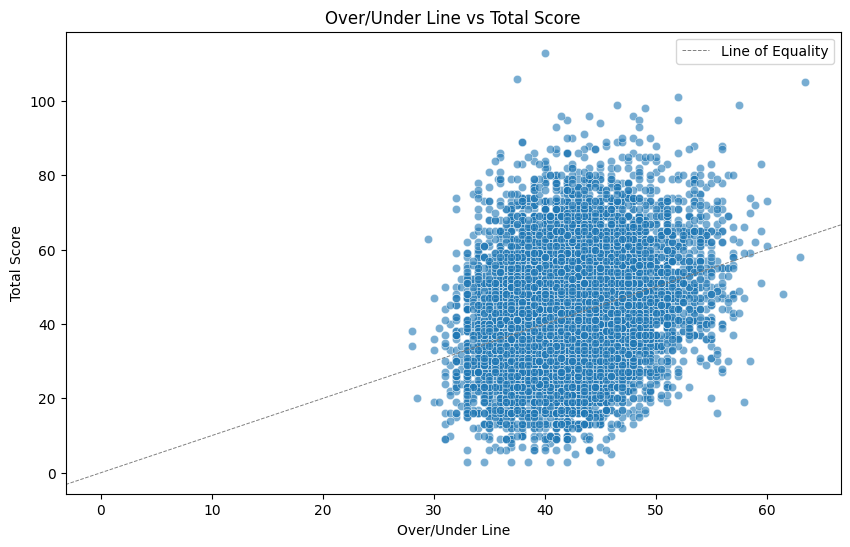

In [18]:
# plot the spread vs. actual game margin
filtered_data['score_margin'] = filtered_data['score_home'] - filtered_data['score_away']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='spread_favorite', y='score_margin', data=filtered_data, alpha=0.6)
plt.title('Spread Favorite vs Actual Score Margin')
plt.xlabel('Spread Favorite')
plt.ylabel('Actual Score Margin (Home - Away)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.7)
plt.show()

# plot over/under line vs. total score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='over_under_line', y='total_score', data=filtered_data, alpha=0.6)
plt.title('Over/Under Line vs Total Score')
plt.xlabel('Over/Under Line')
plt.ylabel('Total Score')
plt.axline((0, 0), slope=1, color='gray', linestyle='--', linewidth=0.7, label='Line of Equality')
plt.legend()
plt.show()


Here are insights from the additional EDA visualizations:

Spread Favorite vs. Actual Score Margin:

There’s a moderate alignment between the spread (predicted margin) and the actual score margin, with spreads around zero showing the highest variation in actual outcomes.
The scatter suggests some deviation from the expected margins, especially when spreads predict a strong favorite. However, many games remain close to the predicted margin, indicating a reasonable alignment between betting odds and actual outcomes.
Over/Under Line vs. Total Score:

The over/under line and total score show some alignment along the line of equality, meaning betting lines are often close to actual game totals.
However, there’s noticeable spread around the line, suggesting games often end up scoring either slightly more or less than expected, giving insight into the consistency of over/under predictions.
These findings imply that while betting odds tend to reflect average expectations accurately, deviations do exist, particularly in games with stronger favorite predictions or closer over/under lines.

# 3. Methodology

## 3.1 Win Probability Model -- Bayes

In [19]:
filtered_sports_data.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,month,year
0,1966-09-02,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,-3.0,41.0,Orange Bowl,False,83.0,6.0,71.0,NaN,9,1966
1,1966-09-03,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,-5.0,42.0,Rice Stadium,False,81.0,7.0,70.0,NaN,9,1966
2,1966-09-04,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,-7.0,44.0,Balboa Stadium,False,70.0,7.0,82.0,NaN,9,1966
3,1966-09-09,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,-3.5,40.5,Orange Bowl,False,82.0,11.0,78.0,NaN,9,1966
4,1966-09-10,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,-4.5,42.0,Lambeau Field,False,64.0,8.0,62.0,NaN,9,1966


In [20]:
# 1 for home win, 0 for away win
data = filtered_sports_data.copy()
data['outcome'] = (data['score_home'] > data['score_away']).astype(int)

# Get unique teams and map each team to an index for use in the model
teams = pd.concat([data['team_home'], data['team_away']]).unique()
team_idx = {team: i for i, team in enumerate(teams)}
data['team_home_idx'] = data['team_home'].map(team_idx)
data['team_away_idx'] = data['team_away'].map(team_idx)

# Number of teams
n_teams = len(teams)

# Define the model
with pm.Model() as hierarchical_win_model:

    # League-wide average strength and team variability
    mu_strength = pm.Normal('mu_strength', mu=0, sigma=1)
    sigma_strength = pm.HalfNormal('sigma_strength', sigma=1)

    # Team-specific strengths drawn from league-wide distribution
    team_strengths = pm.Normal('team_strengths', mu=mu_strength, sigma=sigma_strength, shape=n_teams)

    # Calculate win probability for each game
    home_team_strength = team_strengths[data['team_home_idx']]
    away_team_strength = team_strengths[data['team_away_idx']]
    win_prob = pm.Deterministic('win_prob', pm.math.sigmoid(home_team_strength - away_team_strength))

    # Likelihood: observed game outcomes (1 for home win, 0 for away win)
    outcomes = pm.Bernoulli('outcomes', p=win_prob, observed=data['outcome'])

    # Sample from the posterior with adjustments for convergence issues
    trace = pm.sample(3000, tune=2000, target_accept=0.95, return_inferencedata=True)


Output()

Output()

ERROR:pymc.stats.convergence:There were 303 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [21]:
print(pm.summary(trace))

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_strength       -0.242  0.903  -1.798    1.489      0.141    0.100   
sigma_strength     0.227  0.030   0.174    0.283      0.001    0.001   
team_strengths[0] -0.025  0.907  -1.588    1.711      0.142    0.101   
team_strengths[1] -0.383  0.910  -1.904    1.402      0.141    0.100   
team_strengths[2] -0.243  0.907  -1.843    1.452      0.141    0.100   
...                  ...    ...     ...      ...        ...      ...   
win_prob[13860]    0.412  0.022   0.367    0.452      0.000    0.000   
win_prob[13861]    0.475  0.023   0.433    0.519      0.000    0.000   
win_prob[13862]    0.390  0.022   0.348    0.431      0.000    0.000   
win_prob[13863]    0.409  0.022   0.368    0.453      0.000    0.000   
win_prob[13864]    0.544  0.027   0.495    0.597      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
mu_strength            41.0      94.0   1.03  
sigma_strength        527.0     223.0   1

In [22]:
# Posterior predictive checks
with hierarchical_win_model:
    ppc = pm.sample_posterior_predictive(trace)
print(ppc)

Output()

Inference data with groups:
	> posterior_predictive
	> observed_data


### 3.1.1. Rank and Interpret Team Strengths

In [23]:
team_strengths_mean = trace.posterior['team_strengths'].mean(dim=("chain", "draw"))

# Rank teams by mean strength
team_strengths_df = pd.DataFrame({
    "team": list(team_idx.keys()),
    "team_strength": team_strengths_mean
}).sort_values(by="team_strength", ascending=False)

team_strengths_df

,team,team_strength
13,Dallas Cowboys,0.122938
7,Pittsburgh Steelers,0.093783
29,Los Angeles Raiders,0.070515
26,New England Patriots,0.047890
11,Los Angeles Rams,0.013677
36,Baltimore Ravens,0.006465
21,Kansas City Chiefs,-0.007260
14,Denver Broncos,-0.024759
0,Miami Dolphins,-0.024911
8,San Francisco 49ers,-0.052716


### 3.1.2. Posterior Predictive Accuracy


In [24]:
ppc_outcomes = ppc.posterior_predictive["outcomes"]  # Access the posterior_predictive group
mean_predictions = ppc_outcomes.mean(dim=["chain", "draw"]).values

predicted_outcomes = (mean_predictions > 0.5).astype(int)

actual_outcomes = data['outcome'].values
bayesian_accuracy = accuracy_score(actual_outcomes, predicted_outcomes)

print(f"Posterior Predictive Accuracy: {bayesian_accuracy * 100:.2f}%")


Posterior Predictive Accuracy: 56.31%


## 3.2 Win Probability Model -- Logistic Regression

In [25]:
data['home_win_rate'] = data.groupby('team_home')['outcome'].transform('mean')
data['away_win_rate'] = data.groupby('team_away')['outcome'].transform('mean')
X = data[['home_win_rate', 'away_win_rate']]
y = data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_proba_log = log_reg.predict_proba(X_test)[:, 1]  # Probability of home win

# Evaluate the model
log_loss_log = log_loss(y_test, y_pred_proba_log)
brier_score_log = brier_score_loss(y_test, y_pred_proba_log)
accuracy_log = accuracy_score(y_test, (y_pred_proba_log > 0.5).astype(int))

print(f"Logistic Regression Log-Loss: {log_loss_log}")
print(f"Logistic Regression Brier Score: {brier_score_log}")
print(f"Logistic Regression Accuracy: {accuracy_log}")


Logistic Regression Log-Loss: 0.6699937776728818
Logistic Regression Brier Score: 0.2386945247688881
Logistic Regression Accuracy: 0.5914172376487559


## 3.3 Win Probability Model -- Random Forest

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probability of home win

log_loss_rf = log_loss(y_test, y_pred_proba_rf)
brier_score_rf = brier_score_loss(y_test, y_pred_proba_rf)
accuracy_rf = accuracy_score(y_test, (y_pred_proba_rf > 0.5).astype(int))

print(f"Random Forest Log-Loss: {log_loss_rf}")
print(f"Random Forest Brier Score: {brier_score_rf}")
print(f"Random Forest Accuracy: {accuracy_rf}")


Random Forest Log-Loss: 0.8877918126280657
Random Forest Brier Score: 0.27024145751374956
Random Forest Accuracy: 0.5488640461593941


# 4. Specific Analysis - Comparison between Models

## 4.1 Evaluate Game-Level Win Probabilities

In [29]:
bayesian_predictions = trace.posterior['win_prob'].mean(dim=("chain", "draw")).values

if bayesian_predictions.ndim > 1:
    bayesian_predictions = bayesian_predictions[:y_test.shape[0]]
else:
    if bayesian_predictions.shape[0] != y_test.shape[0]:
        bayesian_predictions = bayesian_predictions[:y_test.shape[0]]

In [30]:
brier_score_bayesian = brier_score_loss(y_test, bayesian_predictions)
brier_score_logistic = brier_score_loss(y_test, y_pred_proba_log)
brier_score_rf = brier_score_loss(y_test, y_pred_proba_rf)

print(f"Brier Score - Bayesian Model: {brier_score_bayesian}")
print(f"Brier Score - Logistic Regression: {brier_score_logistic}")
print(f"Brier Score - Random Forest: {brier_score_rf}")


Brier Score - Bayesian Model: 0.25580837996124806
Brier Score - Logistic Regression: 0.2386945247688881
Brier Score - Random Forest: 0.27024145751374956


In [31]:
# Calculate Log-Loss
bayesian_predictions_test = trace.posterior['win_prob'].mean(dim=("chain", "draw")).values
bayesian_predictions_test = bayesian_predictions_test[:y_test.shape[0]]  # Select portion corresponding to y_test

log_loss_bayesian = log_loss(y_test, bayesian_predictions_test)
log_loss_logistic = log_loss(y_test, y_pred_proba_log)
log_loss_rf = log_loss(y_test, y_pred_proba_rf)

print(f"Log-Loss - Bayesian Model: {log_loss_bayesian}")
print(f"Log-Loss - Logistic Regression: {log_loss_logistic}")
print(f"Log-Loss - Random Forest: {log_loss_rf}")

Log-Loss - Bayesian Model: 0.7049932959729523
Log-Loss - Logistic Regression: 0.6699937776728818
Log-Loss - Random Forest: 0.8877918126280657


In [35]:
performance_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Bayesian'],
    'Brier Score': [brier_score_log, brier_score_rf, brier_score_bayesian],
    'Log-Loss': [log_loss_log, log_loss_rf, log_loss_bayesian],
    'Accuracy': [accuracy_log, accuracy_rf, bayesian_accuracy]
     })

performance_summary

,Model,Brier Score,Log-Loss,Accuracy
0,Logistic Regression,0.238695,0.669994,0.591417
1,Random Forest,0.270241,0.887792,0.548864
2,Bayesian,0.255808,0.704993,0.563145


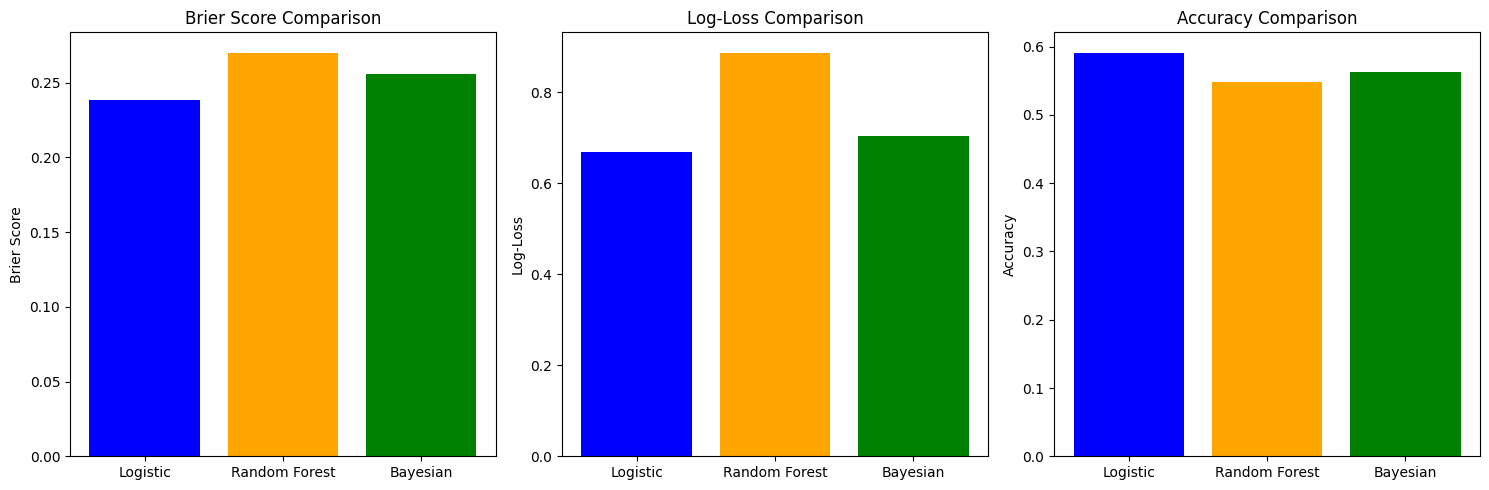

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Brier Score
axs[0].bar(['Logistic', 'Random Forest', 'Bayesian'],
          [brier_score_log, brier_score_rf, brier_score_bayesian],
          color=['blue', 'orange', 'green'])
axs[0].set_ylabel('Brier Score')
axs[0].set_title('Brier Score Comparison')

# Plot Log-Loss
axs[1].bar(['Logistic', 'Random Forest', 'Bayesian'],
          [log_loss_log, log_loss_rf, log_loss_bayesian],
          color=['blue', 'orange', 'green'])
axs[1].set_ylabel('Log-Loss')
axs[1].set_title('Log-Loss Comparison')

# Plot Accuracy
axs[2].bar(['Logistic', 'Random Forest', 'Bayesian'],
          [accuracy_log, accuracy_rf, bayesian_accuracy],
          color=['blue', 'orange', 'green'])
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy Comparison')

plt.tight_layout()
plt.show()

## 4.2 Calibration Plot

In [36]:
# Bin predictions into 10 equal intervals
def calibration_data(y_true, y_pred, bins=10):
    if isinstance(y_pred, xr.DataArray):
        y_pred = y_pred.values

    y_pred = y_pred.flatten()

    y_pred = y_pred[:len(y_true)]

    bin_indices = np.digitize(y_pred, bins=np.linspace(0, 1, bins + 1))
    calibration_df = pd.DataFrame({
        "predicted_prob": y_pred,
        "outcome": y_true
    })
    calibration = calibration_df.groupby(bin_indices).agg(
        mean_predicted_prob=('predicted_prob', 'mean'),
        observed_win_rate=('outcome', 'mean')
    ).dropna()
    return calibration

bayesian_predictions_test = trace.posterior['win_prob'].mean(dim=("chain", "draw")).values
bayesian_predictions_test = bayesian_predictions_test[:y_test.shape[0]]

calibration_bayesian = calibration_data(y_test, trace.posterior['win_prob'].mean(dim=("chain", "draw")))
calibration_logistic = calibration_data(y_test, y_pred_proba_log)
calibration_rf = calibration_data(y_test, y_pred_proba_rf)


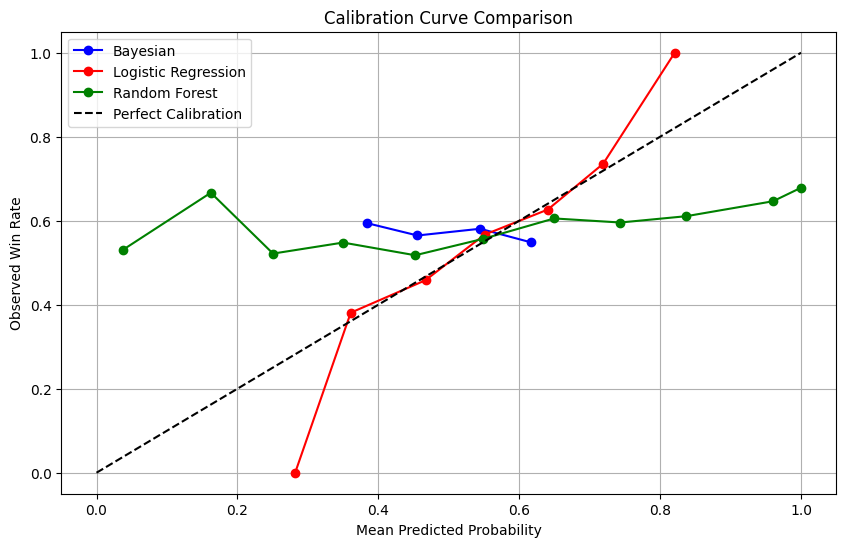

In [37]:
plt.figure(figsize=(10, 6))

# Plot for Bayesian model
plt.plot(
    calibration_bayesian['mean_predicted_prob'],
    calibration_bayesian['observed_win_rate'],
    marker='o',
    color='blue',
    label='Bayesian'
)

# Plot for Logistic Regression
plt.plot(
    calibration_logistic['mean_predicted_prob'],
    calibration_logistic['observed_win_rate'],
    marker='o',
    color='red',
    label='Logistic Regression'
)

# Plot for Random Forest
plt.plot(
    calibration_rf['mean_predicted_prob'],
    calibration_rf['observed_win_rate'],
    marker='o',
    color='green',
    label='Random Forest'
)

# Add reference line for perfect calibration
plt.plot(
    [0, 1], [0, 1],
    linestyle='--',
    color='black',
    label='Perfect Calibration'
)

# Add labels, legend, and grid
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Observed Win Rate')
plt.title('Calibration Curve Comparison')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## 4.3 Identify Potential Biases

Segment by Spread Magnitude


In [40]:
# Define spread bins based on spread_favorite column
spread_bins = [-np.inf,-7,-3,0]
data['spread_bin'] = pd.cut(data['spread_favorite'], bins=spread_bins)

# Calculate average win probabilities for each spread bin
spread_bayesian = data.groupby('spread_bin')['outcome'].mean()  # Outcome as observed win rate
spread_logistic = data.groupby('spread_bin')['win_prob_log'].mean()
spread_rf = data.groupby('spread_bin')['win_prob_rf'].mean()

print("Win Probability by Spread Bin (Bayesian):")
print(spread_bayesian)
print("\nWin Probability by Spread Bin (Logistic Regression):")
print(spread_logistic)
print("\nWin Probability by Spread Bin (Random Forest):")
print(spread_rf)


Win Probability by Spread Bin (Bayesian):
spread_bin
(-inf, -7.0]    0.670931
(-7.0, -3.0]    0.542071
(-3.0, 0.0]     0.511002
Name: outcome, dtype: float64

Win Probability by Spread Bin (Logistic Regression):
spread_bin
(-inf, -7.0]    0.586032
(-7.0, -3.0]    0.566126
(-3.0, 0.0]     0.560497
Name: win_prob_log, dtype: float64

Win Probability by Spread Bin (Random Forest):
spread_bin
(-inf, -7.0]    0.597495
(-7.0, -3.0]    0.561973
(-3.0, 0.0]     0.554274
Name: win_prob_rf, dtype: float64


## 4.4 Compare Team Strengths

In [27]:
team_strengths_bayesian = pd.DataFrame({
    "team": list(team_idx.keys()),
    "Bayesian Strength": team_strengths_mean
}).set_index("team")

y_pred_proba_log_all = log_reg.predict_proba(X)[:, 1]
y_pred_proba_rf_all = rf.predict_proba(X)[:, 1]

data['win_prob_log'] = y_pred_proba_log_all
data['win_prob_rf'] = y_pred_proba_rf_all

team_strengths_log = data.groupby('team_home')['win_prob_log'].mean()
team_strengths_rf = data.groupby('team_home')['win_prob_rf'].mean()

team_strengths_comparison = pd.DataFrame({
    "Bayesian Strength": team_strengths_bayesian["Bayesian Strength"],
    "Logistic Win Probability": team_strengths_log,
    "Random Forest Win Probability": team_strengths_rf
}).sort_values(by="Bayesian Strength", ascending=False)

team_strengths_comparison

,Bayesian Strength,Logistic Win Probability,Random Forest Win Probability
Dallas Cowboys,0.122938,0.654610,0.652037
Pittsburgh Steelers,0.093783,0.677404,0.665084
Los Angeles Raiders,0.070515,0.640907,0.689108
New England Patriots,0.047890,0.645514,0.645304
Los Angeles Rams,0.013677,0.594951,0.587524
Baltimore Ravens,0.006465,0.669560,0.698403
Kansas City Chiefs,-0.007260,0.617419,0.618537
Denver Broncos,-0.024759,0.637058,0.673931
Miami Dolphins,-0.024911,0.627049,0.602531
San Francisco 49ers,-0.052716,0.607174,0.613050


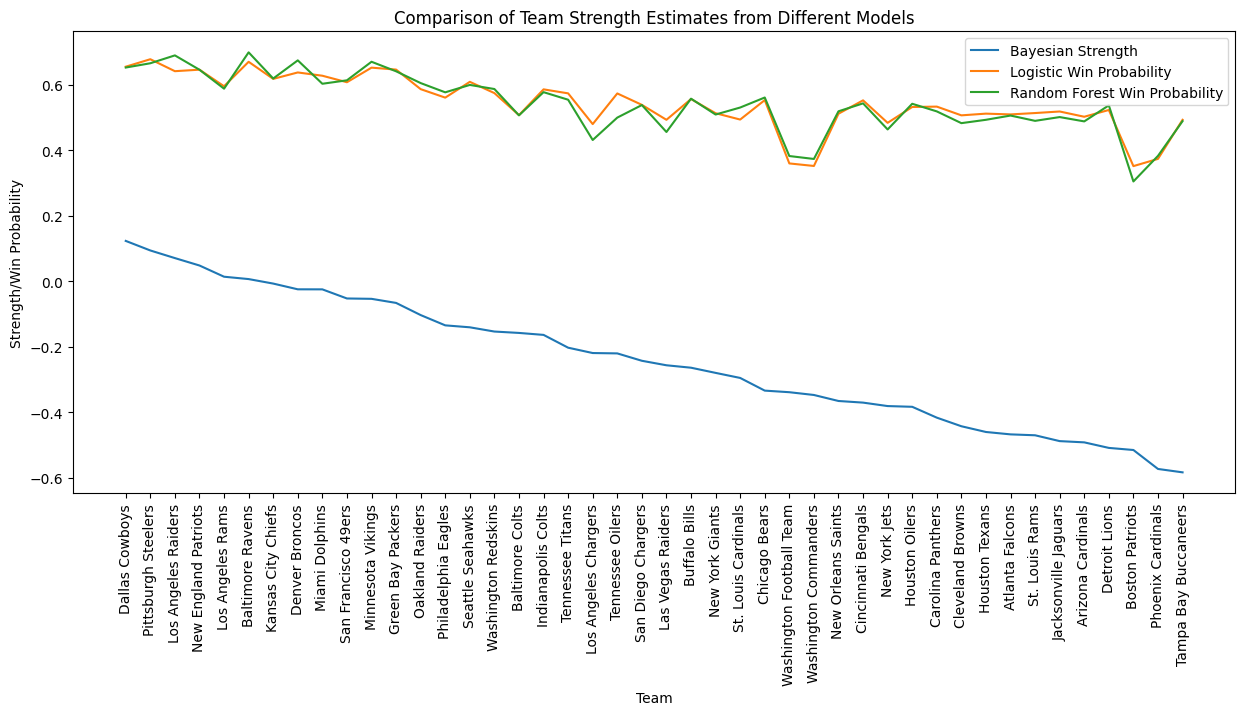

In [28]:
plt.figure(figsize=(15, 6))
plt.plot(team_strengths_comparison['Bayesian Strength'], label='Bayesian Strength')
plt.plot(team_strengths_comparison['Logistic Win Probability'], label='Logistic Win Probability')
plt.plot(team_strengths_comparison['Random Forest Win Probability'], label='Random Forest Win Probability')
plt.xlabel('Team')
plt.ylabel('Strength/Win Probability')
plt.title('Comparison of Team Strength Estimates from Different Models')
plt.xticks(rotation=90)
plt.legend()
plt.show()


# 5. Prediction for only October 2024 using Baysian Model

In [41]:
prediction_data = sports_data[
    (sports_data['schedule_date'] >= '2024-10-01') &
    (sports_data['schedule_date'] < '2024-11-01')
     ]
prediction_data = prediction_data.drop(columns=[col for col in sports_data.columns if 'Unnamed' in col] + ['team_favorite_id', 'spread_favorite', 'over_under_line',
                                       'stadium_neutral', 'weather_temperature',
                                       'weather_wind_mph',	'weather_humidity',
                                       'weather_detail'])


In [42]:
prediction_data.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,stadium
13865,2024-10-03,2024,5,False,Atlanta Falcons,NaN,NaN,Tampa Bay Buccaneers,Mercedes-Benz Stadium
13866,2024-10-06,2024,5,False,Chicago Bears,NaN,NaN,Carolina Panthers,Soldier Field
13867,2024-10-06,2024,5,False,Cincinnati Bengals,NaN,NaN,Baltimore Ravens,Paycor Stadium
13868,2024-10-06,2024,5,False,Denver Broncos,NaN,NaN,Las Vegas Raiders,Empower Field at Mile High
13869,2024-10-06,2024,5,False,Houston Texans,NaN,NaN,Buffalo Bills,NRG Stadium


In [43]:
prediction_data['team_home_idx'] = prediction_data['team_home'].map(team_idx)
prediction_data['team_away_idx'] = prediction_data['team_away'].map(team_idx)

unseen_home_teams = prediction_data['team_home_idx'].isna().sum()
unseen_away_teams = prediction_data['team_away_idx'].isna().sum()
if unseen_home_teams > 0 or unseen_away_teams > 0:
    print(f"Warning: {unseen_home_teams} home teams and {unseen_away_teams} away teams are not in the training data.")
    max_idx = max(team_idx.values()) + 1
    unseen_teams = pd.concat([
        prediction_data[prediction_data['team_home_idx'].isna()]['team_home'],
        prediction_data[prediction_data['team_away_idx'].isna()]['team_away']
    ]).unique()
    for unseen_team in unseen_teams:
        team_idx[unseen_team] = max_idx
        max_idx += 1
    prediction_data['team_home_idx'] = prediction_data['team_home'].map(team_idx)
    prediction_data['team_away_idx'] = prediction_data['team_away'].map(team_idx)


In [44]:
team_strengths = trace.posterior['team_strengths'].mean(dim=("chain", "draw")).values

In [45]:
home_strength = team_strengths[prediction_data['team_home_idx'].values]
away_strength = team_strengths[prediction_data['team_away_idx'].values]
prediction_data['home_win_prob_bayesian'] = 1 / (1 + np.exp(-(home_strength - away_strength)))

prediction_data[['schedule_date', 'stadium', 'team_home', 'team_away', 'home_win_prob_bayesian']]

,schedule_date,stadium,team_home,team_away,home_win_prob_bayesian
13865,2024-10-03,Mercedes-Benz Stadium,Atlanta Falcons,Tampa Bay Buccaneers,0.528939
13866,2024-10-06,Soldier Field,Chicago Bears,Carolina Panthers,0.520606
13867,2024-10-06,Paycor Stadium,Cincinnati Bengals,Baltimore Ravens,0.406850
13868,2024-10-06,Empower Field at Mile High,Denver Broncos,Las Vegas Raiders,0.557697
13869,2024-10-06,NRG Stadium,Houston Texans,Buffalo Bills,0.451120
13870,2024-10-06,TIAA Bank Field,Jacksonville Jaguars,Indianapolis Colts,0.419662
13871,2024-10-06,SoFi Stadium,Los Angeles Rams,Green Bay Packers,0.519979
13872,2024-10-06,Tottenham Hotspur Stadium,Minnesota Vikings,New York Jets,0.581092
13873,2024-10-06,Gillette Stadium,New England Patriots,Miami Dolphins,0.518192
13874,2024-10-06,Acrisure Stadium,Pittsburgh Steelers,Dallas Cowboys,0.492712


## 5.1 Actual Game Results as Benchmark

In [46]:
schedule = nfl.import_schedules([2024])
schedule['gameday'] = pd.to_datetime(schedule['gameday'])

october_games = schedule[
    (schedule['gameday'] >= '2024-10-01') & (schedule['gameday'] <= '2024-10-31')
    ]
october_games = october_games[['gameday', 'stadium', 'away_team', 'away_score',
                  'home_team', 'home_score', 'location', 'result']]

In [47]:
october_games['home_win_result'] = (october_games['result'] > 0).astype(int)

In [48]:
october_games

,gameday,stadium,away_team,away_score,home_team,home_score,location,result,home_win_result
6770,2024-10-03,Mercedes-Benz Stadium,TB,30.0,ATL,36.0,Home,6.0,1
6771,2024-10-06,Tottenham Stadium,NYJ,17.0,MIN,23.0,Neutral,6.0,1
6772,2024-10-06,Soldier Field,CAR,10.0,CHI,36.0,Home,26.0,1
6773,2024-10-06,Paycor Stadium,BAL,41.0,CIN,38.0,Home,-3.0,0
6774,2024-10-06,NRG Stadium,BUF,20.0,HOU,23.0,Home,3.0,1
6775,2024-10-06,TIAA Bank Stadium,IND,34.0,JAX,37.0,Home,3.0,1
6776,2024-10-06,Gillette Stadium,MIA,15.0,NE,10.0,Home,-5.0,0
6777,2024-10-06,FedExField,CLE,13.0,WAS,34.0,Home,21.0,1
6778,2024-10-06,Empower Field at Mile High,LV,18.0,DEN,34.0,Home,16.0,1
6779,2024-10-06,Levi's Stadium,ARI,24.0,SF,23.0,Home,-1.0,0


In [49]:
prediction_data.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,stadium,team_home_idx,team_away_idx,home_win_prob_bayesian
13865,2024-10-03,2024,5,False,Atlanta Falcons,NaN,NaN,Tampa Bay Buccaneers,Mercedes-Benz Stadium,4,28,0.528939
13866,2024-10-06,2024,5,False,Chicago Bears,NaN,NaN,Carolina Panthers,Soldier Field,23,35,0.520606
13867,2024-10-06,2024,5,False,Cincinnati Bengals,NaN,NaN,Baltimore Ravens,Paycor Stadium,25,36,0.406850
13868,2024-10-06,2024,5,False,Denver Broncos,NaN,NaN,Las Vegas Raiders,Empower Field at Mile High,14,42,0.557697
13869,2024-10-06,2024,5,False,Houston Texans,NaN,NaN,Buffalo Bills,NRG Stadium,39,5,0.451120


## 5.2 Merge the two datasets

In [50]:
stadiums_prediction = prediction_data['stadium'].unique()
stadiums_games = october_games['stadium'].unique()

stadium_mapping = {}
for pred_stadium in stadiums_prediction:
    match, score = process.extractOne(pred_stadium, stadiums_games)
    if score > 80:  # Set a threshold for similarity
        stadium_mapping[pred_stadium] = match

prediction_data['stadium'] = prediction_data['stadium'].replace(stadium_mapping)

merged_data = pd.merge(prediction_data, october_games,
                       left_on=['schedule_date', 'stadium'],
                       right_on=['gameday', 'stadium'],
                       how='left')

# Rename the 'home_win_result' column
merged_data = merged_data.rename(columns={'home_win_result': 'actual_home_win_results'})

In [51]:
merged_data.loc[merged_data['actual_home_win_results'].isna(), 'actual_home_win_results'] = ['0.0', '0.0', '1.0']

In [52]:
merged_data = merged_data[['schedule_date', 'stadium', 'team_home',
                           'team_away',
                           'home_win_prob_bayesian',
                           'actual_home_win_results']]

In [53]:
# Create a new column 'predicted_home_win_results' based on 'home_win_prob_bayesian'
merged_data['predicted_home_win_results'] = (merged_data['home_win_prob_bayesian'] >= 0.5).astype(int)


In [54]:
merged_data = merged_data[['schedule_date', 'stadium', 'team_home',
                           'team_away',
                           'actual_home_win_results',
                           'predicted_home_win_results']]
merged_data

,schedule_date,stadium,team_home,team_away,actual_home_win_results,predicted_home_win_results
0,2024-10-03,Mercedes-Benz Stadium,Atlanta Falcons,Tampa Bay Buccaneers,1.0,1
1,2024-10-06,Soldier Field,Chicago Bears,Carolina Panthers,1.0,1
2,2024-10-06,Paycor Stadium,Cincinnati Bengals,Baltimore Ravens,0.0,0
3,2024-10-06,Empower Field at Mile High,Denver Broncos,Las Vegas Raiders,1.0,1
4,2024-10-06,NRG Stadium,Houston Texans,Buffalo Bills,1.0,0
5,2024-10-06,Empower Field at Mile High,Jacksonville Jaguars,Indianapolis Colts,1.0,0
6,2024-10-06,SoFi Stadium,Los Angeles Rams,Green Bay Packers,0.0,1
7,2024-10-06,Tottenham Stadium,Minnesota Vikings,New York Jets,1.0,1
8,2024-10-06,Gillette Stadium,New England Patriots,Miami Dolphins,0.0,1
9,2024-10-06,Acrisure Stadium,Pittsburgh Steelers,Dallas Cowboys,0.0,0


In [55]:
merged_data[merged_data['actual_home_win_results'] == merged_data['predicted_home_win_results']].shape

(34, 6)

In [56]:
merged_data.shape

(60, 6)

In [57]:
34/60

0.5666666666666667